# Analysis of digitized base circles

In [1]:
# Python base
from itertools import count
from pathlib import Path

# Data analysis
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# fractopo-subsampling imports
import fractopo_subsampling.utils as utils
import fractopo_subsampling.plotting_utils as plotting_utils

# local config file (./subsampling_config.py)
import subsampling_config

In [3]:
# Set seaborn theme
sns.set_theme(context="paper", style="ticks", font_scale=1.3)

## Read data

In [4]:
# Read data from path set in ./subsampling_config.py
all_analysis_points = gpd.read_file(subsampling_config.analysis_points_path)

Data is filtered to only selected target areas, the base circles, which are spatially concentrated. 

Neither radius or coverage filter affects this dataset as all the base circles fit the filters.

In [5]:
# Filter out target areas other than the 13 base circles
geta_base_circles = utils.filter_dataframe(
    all_analysis_points,
    list(subsampling_config.circle_names_with_diameter),
    filter_radius=(5, 51),
    relative_coverage_threshold=0.15,
)

Name filtered: 7
Radius filtered: 0
Coverage filtered: 0


The maximum relative coverage is:

In [6]:
geta_base_circles[utils.Utils.relative_coverage].max()

0.10091961442281777

In [7]:
all_analysis_points.shape[0], geta_base_circles.shape[0]

(20, 13)

Shoreline dataset contains a rough sketch of the Getaberget shoreline for visualization purposes only.

In [8]:
shoreline = gpd.read_file(subsampling_config.shoreline_geojson_url)

## Determine reference values for subsampling analyses

The parameter values determined from the full dataset should represent the most accurate assesment if more area equals better results.

Because the full circle radii vary, the achieved parameter results are weighted by the area of the circle to make the larger base circles have more weight on the parameter averages.

In [9]:
# Determine reference_values into a dict
reference_values = {
    utils.param_renamer(param): round(
        np.average(geta_base_circles[param], weights=geta_base_circles["area"]), 4
    )
    for param in utils.Utils.params_with_func
    if param in utils.Utils.selected_params
}

# Make into DataFrame, save to local csv file
reference_value_df = pd.DataFrame(
    {"Parameter": reference_values.keys(), "Value": reference_values.values()}
)
reference_value_df.to_csv(
    subsampling_config.base_circle_reference_value_csv_path, index=False
)

In [10]:
reference_value_df

,Parameter,Value
0,Fracture Intensity P21,2.0089
1,Connections per Branch,1.4435
2,Trace Power-law Exponent,-1.7546
3,Branch Power-law Exponent,-2.9051


Total area in base circles in $m^2$.

In [11]:
geta_base_circles["area"].sum(), geta_base_circles["Number of Traces"].sum()

(20813.051330032384, 40654.0)

## Spatial variance analysis of parameters

Do parameters have a direct correlation with their spatial location in E-W-axis?

In [12]:
# Define numerical xy coordinates from Points
geta_base_circles["x"] = [point.x for point in geta_base_circles.geometry.values]
geta_base_circles["y"] = [point.y for point in geta_base_circles.geometry.values]

In [13]:
geta_base_circles["name"]

1     Getaberget_20m_1_1_area
2     Getaberget_20m_1_2_area
3     Getaberget_20m_1_3_area
4     Getaberget_20m_1_4_area
5     Getaberget_20m_2_1_area
6     Getaberget_20m_2_2_area
12    Getaberget_20m_4_3_area
13    Getaberget_20m_5_1_area
14    Getaberget_20m_7_1_area
15    Getaberget_20m_7_2_area
16    Getaberget_20m_8_3_area
17    Getaberget_20m_9_2_area
18      Havsvidden_20m_1_area
Name: name, dtype: object

<AxesSubplot:>

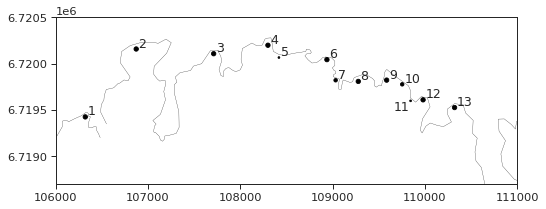

In [14]:
# Simple map of base circle locations
plotting_utils.plot_base_circle_map(filtered=geta_base_circles, shoreline=shoreline)

In [15]:
# Name the base circles with IDs based on sorted X-coordinate values
coords = plotting_utils.base_circle_id_coords(geta_base_circles)
id_dict = plotting_utils.base_circle_id_dict(coords)
id_dict

{'Getaberget_20m_4_3_area': 1,
 'Getaberget_20m_9_2_area': 2,
 'Getaberget_20m_8_3_area': 3,
 'Getaberget_20m_7_1_area': 4,
 'Getaberget_20m_7_2_area': 5,
 'Getaberget_20m_5_1_area': 6,
 'Getaberget_20m_2_1_area': 7,
 'Getaberget_20m_2_2_area': 8,
 'Getaberget_20m_1_1_area': 9,
 'Getaberget_20m_1_2_area': 10,
 'Getaberget_20m_1_3_area': 11,
 'Getaberget_20m_1_4_area': 12,
 'Havsvidden_20m_1_area': 13}

In [16]:
base_circle_dicts = []
for key, value in id_dict.items():
    base_circle_dict = dict()
    base_circle_dict["ID"] = value
    base_circle_dict["Radius (m)"] = geta_base_circles["radius"].values[geta_base_circles["name"] == key][
        0
    ]
    base_circle_dict["Name"] = key
    base_circle_dicts.append(base_circle_dict)
df = pd.DataFrame(base_circle_dicts)

# Update a local file with always correct ids for all base circles
df.to_csv(subsampling_config.base_circle_ids_csv_path, index=False)

In [17]:
# Update geta_base_circles with IDs
geta_base_circles["CIRCLE_ID"] = [id_dict[name] for name in geta_base_circles["name"].values]

# Have to drop x and y to save as GeoPackage
geta_base_circles.drop(columns=["x", "y"]).to_file(
    subsampling_config.filtered_analysis_points, driver="GPKG"
)

In [18]:
def format_func_m_to_km(value, tick_number):
    return int(value / 1000)

## Base circle characterization

Plot parameter values as a function x-coordinate for the four parameters.

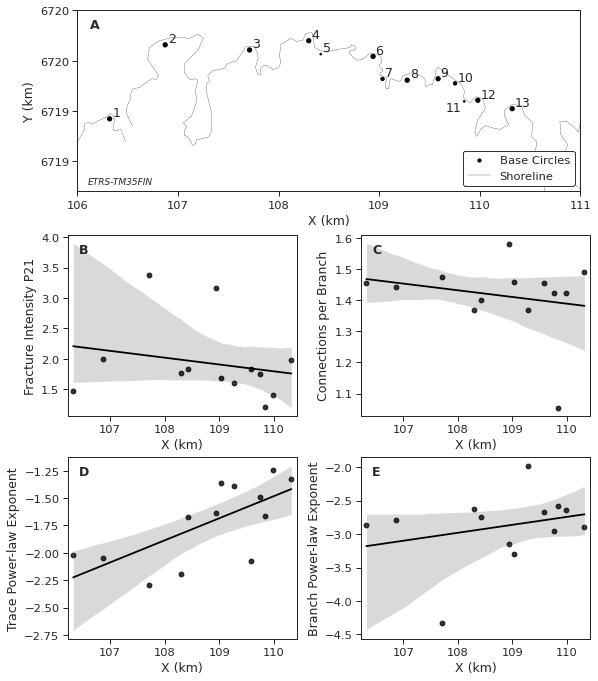

In [19]:
fig = plt.figure(constrained_layout=True, figsize=utils.paper_figsize(0.8))

gs = fig.add_gridspec(3, 2)

fig_top_ax = fig.add_subplot(gs[0, :])
fig_left_middle = fig.add_subplot(gs[1, 0])
fig_right_middle = fig.add_subplot(gs[1, 1])
fig_left_bot = fig.add_subplot(gs[2, 0])
fig_right_bot = fig.add_subplot(gs[2, 1])


fig_top_ax = plotting_utils.plot_base_circle_map(
    filtered=geta_base_circles, shoreline=shoreline, ax=fig_top_ax
)

fig_top_ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))
fig_top_ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))

fig_top_ax.set_ylabel("Y (km)")
fig_top_ax.set_xlabel("X (km)")
fig_top_ax.legend(**{"edgecolor": "black", "loc": "lower right", "framealpha": 1})
fig_top_ax.text(0.025, 0.9, "A", transform=fig_top_ax.transAxes, fontweight="bold")
fig_top_ax.text(
    0.020,
    0.04,
    "ETRS-TM35FIN",
    transform=fig_top_ax.transAxes,
    fontsize=9,
    style="italic",
)

# fig, axes = plt.subplots(3, 2, figsize=utils.paper_figsize(1), sharex=True)
for param, ax, text in zip(
    list(utils.Utils.params_with_func)[0:4],
    [fig_left_middle, fig_right_middle, fig_left_bot, fig_right_bot],
    ("B", "C", "D", "E"),
):
    sns.regplot(data=geta_base_circles, x="x", y=param, ax=ax, ci=95, color="black")
    if param != utils.param_renamer(param):
        ax.set_ylabel(utils.param_renamer(param))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))
    ax.set_xlabel("X (km)")
    ax.set_xlim(min(geta_base_circles["x"]) - 100, max(geta_base_circles["x"]) + 100)
    ax.text(0.05, 0.9, text, transform=ax.transAxes, fontweight="bold")

fig.savefig(
    subsampling_config.results_path / "base_circle_map.svg", bbox_inches="tight"
)

## Miscellaneous analyses

Simplify the significance of powerlaw vs. lognormal distribution comparison for traces.

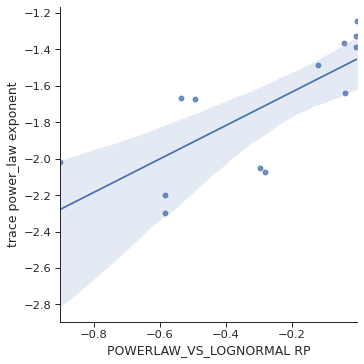

In [20]:
# Simplify significance of powerlaw vs. lognormal distribution comparison
geta_base_circles["POWERLAW_VS_LOGNORMAL RP"] = [
    val if r > 0 else -val
    for val, r in zip(
        geta_base_circles[utils.Utils.trace_power_law_vs_lognormal_p],
        geta_base_circles[utils.Utils.trace_power_law_vs_lognormal_r],
    )
]

for param in utils.Utils.params_with_func:
    sns.lmplot(
        data=geta_base_circles, x="POWERLAW_VS_LOGNORMAL RP", y="trace power_law exponent"
    )
    break

Plot RP and cut-off.

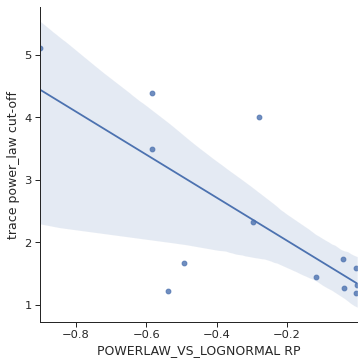

In [21]:
sns.lmplot(data=geta_base_circles, x="POWERLAW_VS_LOGNORMAL RP", y="trace power_law cut-off")

Simplify the significance of powerlaw vs. lognormal distribution comparison for branches.

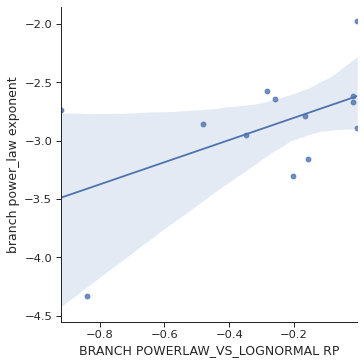

In [22]:
# Simplify significance of powerlaw vs. lognormal distribution comparison
geta_base_circles["BRANCH POWERLAW_VS_LOGNORMAL RP"] = [
    val if r > 0 else -val
    for val, r in zip(
        geta_base_circles[utils.Utils.trace_power_law_vs_lognormal_p.replace("trace", "branch")],
        geta_base_circles[utils.Utils.trace_power_law_vs_lognormal_r.replace("trace", "branch")],
    )
]

for param in utils.Utils.params_with_func:
    sns.lmplot(
        data=geta_base_circles,
        x="BRANCH POWERLAW_VS_LOGNORMAL RP",
        y="branch power_law exponent",
    )
    break

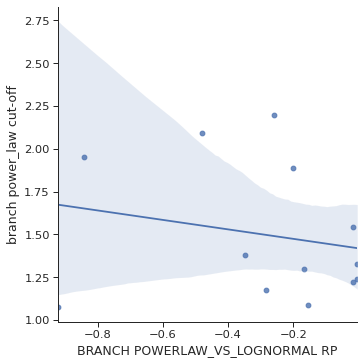

In [23]:
sns.lmplot(
    data=geta_base_circles, x="BRANCH POWERLAW_VS_LOGNORMAL RP", y="branch power_law cut-off"
)